In [1]:
# Build an emulator based on data from all basins
# Investigate different emulator set up and methods
# spatial CV

In [2]:

import glob
import os
import sys

import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

sys.path.append("../MOASMO_support")
from MOASMO_parameters import *

sys.path.append("/glade/u/home/guoqiang/CTSM_repos/ctsm_optz/MO-ASMO/src")
import NSGA2


def get_modified_KGE(obs,sim):
    ind = (~np.isnan(obs)) & (~np.isnan(sim))
    obs = obs[ind]
    sim = sim[ind]

    try:
        sd_sim=np.std(sim, ddof=1)
        sd_obs=np.std(obs, ddof=1)
        m_sim=np.mean(sim)
        m_obs=np.mean(obs)
        r=(np.corrcoef(sim,obs))[0,1]
        relvar=(float(sd_sim)/float(m_sim))/(float(sd_obs)/float(m_obs))
        bias=float(m_sim)/float(m_obs)
        kge=1.0-np.sqrt((r-1)**2 +(relvar-1)**2 + (bias-1)**2)
    except:
        kge = np.nan

    return kge, r, bias, relvar


def read_ctsm_default_parameters(param_names, param_sources, path_CTSM_case):
    # use functions from MOASMO_parameters
    param0 = []
    for j in range(len(param_names)):
        param0.append(get_parameter_value_from_CTSM_case(param_names[j], param_sources[j], path_CTSM_case))
    
    return param0

In [3]:
ncpus = 10

# Load data for all basins

In [4]:
# load basin info
infile_basin_info = f"/glade/work/guoqiang/CTSM_CAMELS/data_mesh_surf/HillslopeHydrology/CAMELS_level1_basin_info.csv"
df_basin_info = pd.read_csv(infile_basin_info)

In [5]:
# load all parameters
# note that only some are used for specific basins
infile_param_info = '/glade/u/home/guoqiang/CTSM_repos/CTSM_calibration/src/parameter/CTSM_CAMELS_SA_param_240202.csv'
df_param_info = pd.read_csv(infile_param_info)

In [6]:
# load basin attributes for this cluster
attfiles = [
    "/glade/campaign/ral/hap/common/camels/camels_geol.txt",
    "/glade/campaign/ral/hap/common/camels/camels_hydro.txt",
    "/glade/campaign/ral/hap/common/camels/camels_clim.txt",
    "/glade/campaign/ral/hap/common/camels/camels_loc_topo.txt",
    "/glade/campaign/ral/hap/common/camels/camels_soil.txt",
    "/glade/campaign/ral/hap/common/camels/camels_vege.txt",
]

for i in range(len(attfiles)):
    dfi = pd.read_csv(attfiles[i], delimiter=";")
    if i == 0:
        df_att = dfi
    else:
        df_att = pd.merge(df_att, dfi, on="gauge_id")

df_att = df_att.loc[df_att["gauge_id"].isin(df_basin_info["hru_id"].values)]
df_att.sel_index = np.arange(len(df_att))
if np.any(df_att["gauge_id"].values != df_basin_info["hru_id"].values):
    sys.exit("Mismatch between att and info ids")
else:
    print("att and info ids match")
    df_att["hru_id"] = df_basin_info["hru_id"].values

print("All columns are")
print(df_att.columns)

# for string columns, convert they to integers

att and info ids match
All columns are
Index(['gauge_id', 'geol_1st_class', 'glim_1st_class_frac', 'geol_2nd_class',
       'glim_2nd_class_frac', 'carbonate_rocks_frac', 'geol_porostiy',
       'geol_permeability', 'q_mean', 'runoff_ratio', 'slope_fdc',
       'baseflow_index', 'stream_elas', 'q5', 'q95', 'high_q_freq',
       'high_q_dur', 'low_q_freq', 'low_q_dur', 'zero_q_freq', 'hfd_mean',
       'p_mean', 'pet_mean', 'p_seasonality', 'frac_snow', 'aridity',
       'high_prec_freq', 'high_prec_dur', 'high_prec_timing', 'low_prec_freq',
       'low_prec_dur', 'low_prec_timing', 'huc_02', 'gauge_name', 'gauge_lat',
       'gauge_lon', 'mean_elev', 'mean_slope', 'area_gauges2',
       'area_geospa_fabric', 'abs_rel_error_area', 'soil_depth_pelletier',
       'soil_depth_statsgo', 'soil_porosity', 'soil_conductivity',
       'max_water_content', 'sand_frac', 'silt_frac', 'clay_frac',
       'water_frac', 'organic_frac', 'other_frac', 'frac_forest', 'lai_max',
       'lai_diff', 'gvf_m

# Load MO-ASMO outputs (metrics and parameters)
Iteration-0

In [7]:
inpath_moasmo = "/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange"

In [8]:
# load default parameters for each basin
param_names = df_param_info['Parameter'].values
param_sources = df_param_info['Source'].values

file_defa_param = 'camels_627basin_ctsm_defa_param.csv'

if os.path.isfile(file_defa_param):
    df_param_defa = pd.read_csv(file_defa_param)
else:
    pathctsm = '/glade/work/guoqiang/CTSM_CAMELS/Calib_HH_MOASMO_bigrange'
    param_defa = np.nan * np.zeros([len(df_basin_info), len(df_param_info)])
    for i in range(len(df_basin_info)):
        path_CTSM_case = f'{pathctsm}/level1_{i}'
        parami_all = read_ctsm_default_parameters(param_names, param_sources, path_CTSM_case)
        parami_mean = [np.mean(p) for p in parami_all]
        param_defa[i, :] = parami_mean
    
    df_param_defa = pd.DataFrame(param_defa, columns=param_names)
    df_param_defa.to_csv(file_defa_param, index=False)

In [9]:
# load parameter values from all basins

file_all_param = 'camels_627basin_ctsm_all_param.csv.gz'

if os.path.isfile(file_all_param):
    df_param = pd.read_csv(file_all_param, compression='gzip')

else:

    df_param = pd.DataFrame()
    
    flag = 0
    for i in range(len(df_basin_info)):
        file_param = f"{inpath_moasmo}/level1_{i}_MOASMOcalib/ctsm_outputs/iter0_all_meanparam.csv"
        df1 = pd.read_csv(file_param)
      
        parami = np.tile(df_param_defa.iloc[i].values, (len(df1), 1))
        for j in range(len(df1.columns)):
            if df1.columns[j] in param_names: # skip binded parameters
                indj = np.where(param_names==df1.columns[j])[0][0]
                parami[:,indj] = df1.values[:,j]
    
        df1 = pd.DataFrame(parami, columns=param_names)
        
    
        if len(df_param) == 0:
            df_param = df1
        else:
            df_param = pd.concat([df_param, df1])
    
        flag = flag + 1
    
    
    df_param.index = np.arange(len(df_param))
    df_param.to_csv(file_all_param, index=False, compression='gzip')


In [10]:
# load parameter upper/lower bounds for all basins

file_param_lb = 'camels_627basin_ctsm_all_param_lb.csv.gz'
file_param_ub = 'camels_627basin_ctsm_all_param_ub.csv.gz'

if os.path.isfile(file_param_lb):
    df_param_lb = pd.read_csv(file_param_lb, compression='gzip')
    df_param_ub = pd.read_csv(file_param_ub, compression='gzip')

else:
    
    param_lb_values = df_param_defa.values.copy()
    param_ub_values = df_param_defa.values.copy()
    
    for i in range(len(df_basin_info)):
        file = f"{inpath_moasmo}/level1_{i}_MOASMOcalib/param_sets/all_default_parameters.pkl"
        dfi = pd.read_pickle(file)
    
        for j in range(len(dfi['Parameter'].values)):
            indj = np.where(df_param_defa.columns.values==dfi['Parameter'].values[j])[0][0]
            param_lb_values[i, indj] = dfi['Lower'].values[j]
            param_ub_values[i, indj] = dfi['Upper'].values[j]
    
    df_param_lb = pd.DataFrame(param_lb_values, columns=df_param_defa.columns.values)
    df_param_ub = pd.DataFrame(param_ub_values, columns=df_param_defa.columns.values)
    
    df_param_lb.to_csv(file_param_lb, index=False, compression='gzip')
    df_param_ub.to_csv(file_param_ub, index=False, compression='gzip')

In [11]:
# load metric values from all basins

file_all_metric = 'camels_627basin_ctsm_all_metric.csv.gz'
file_all_basinid = 'camels_627basin_ctsm_all_basinid.csv.gz'

if os.path.isfile(file_all_param):
    df_metric = pd.read_csv(file_all_metric, compression='gzip')
    df_basinid = pd.read_csv(file_all_basinid, compression='gzip')

else:

    df_metric = pd.DataFrame()
    
    flag = 0
    for i in range(len(df_basin_info)):
        # file_metric = f"{inpath_moasmo}/level1_{i}_MOASMOcalib/ctsm_outputs/iter0_all_metric.csv"
        
        file_metric = f"{inpath_moasmo}/level1_{i}_MOASMOcalib/ctsm_outputs/iter0_many_metric.csv"
        df2 = pd.read_csv(file_metric)
        metnames = df2.columns
    
        df2["basin_num"] = flag
        df2["basin_id"] = i
        df2["hru_id"] = df_basin_info["hru_id"].values[flag]
    
        if len(df_metric) == 0:
            df_metric = df2
        else:
            df_metric = pd.concat([df_metric, df2])
    
        flag = flag + 1

    df_metric.index = np.arange(len(df_metric))
    
    df_basinid = df_metric[["basin_num", "basin_id", "hru_id"]]
    # df_metric = df_metric[["metric1", "metric2"]]
    # df_metric = df_metric[metnames]
    selected_met =['kge', 'mae', 'n_mae', 'nse', 'cc', 'rmse', 'max_mon_abs_err', 'n_max_mon_abs_err',  'kge_log_q']
    df_metric = df_metric[selected_met]
    df_metric.to_csv(file_all_metric, index=False, compression='gzip')
    df_basinid.to_csv(file_all_basinid, index=False, compression='gzip')

In [12]:
# remove nan values (some failed models)
index = np.isnan(np.sum(df_metric.values, axis=1))
df_param = df_param[~index]
df_metric = df_metric[~index]
df_basinid = df_basinid[~index]

df_param.index = np.arange(len(df_param))
df_metric.index = np.arange(len(df_metric))
df_basinid.index = np.arange(len(df_basinid))

print('Number of nan samples:', np.sum(index))
print("Number of original parameter sets:", len(index))
print("Number of final parameter sets:", len(df_param))

Number of nan samples: 3709
Number of original parameter sets: 250800
Number of final parameter sets: 247091


# Create inputs by appending geo attributes

attribute selection
Reference:
Feng, Dapeng, Kuai Fang, and Chaopeng Shen. "Enhancing streamflow forecast and extracting insights using long‐short term memory networks with data integration at continental scales." Water Resources Research 56, no. 9 (2020): e2019WR026793.

Xie, Kang, Pan Liu, Jianyun Zhang, Dongyang Han, Guoqing Wang, and Chaopeng Shen. "Physics-guided deep learning for rainfall-runoff modeling by considering extreme events and monotonic relationships." Journal of Hydrology 603 (2021): 127043.

Ouyang, Wenyu, Kathryn Lawson, Dapeng Feng, Lei Ye, Chi Zhang, and Chaopeng Shen. "Continental-scale streamflow modeling of basins with reservoirs: Towards a coherent deep-learning-based strategy." Journal of Hydrology 599 (2021): 126455.

Atts:

att_Feng2020 = { "elev_mean": {"description": "Catchment mean elevation", "unit": "m"}, "slope_mean": {"description": "Catchment mean slope", "unit": "m/km"}, "area_gages2": {"description": "Catchment area (GAGESII estimate)", "unit": "km2"}, "frac_forest": {"description": "Forest fraction", "unit": "—"}, "lai_max": {"description": "Maximum monthly mean of the leaf area index", "unit": "—"}, "lai_diff": {"description": "Difference between the maximum and minimum monthly mean of the leaf area index", "unit": "—"}, "dom_land_cover_frac": {"description": "Fraction of the catchment area associated with the dominant land cover", "unit": "—"}, "dom_land_cover": {"description": "Dominant land cover type", "unit": "—"}, "root_depth_50": {"description": "Root depth at 50th percentile, extracted from a root depth distribution based on the International Geosphere-Biosphere Programme (IGBP) land cover", "unit": "m"}, "soil_depth_statgso": {"description": "Soil depth", "unit": "m"}, "soil_porosity": {"description": "Volumetric soil porosity", "unit": "—"}, "soil_conductivity": {"description": "Saturated hydraulic conductivity", "unit": "cm/hr"}, "max_water_content": {"description": "Maximum water content", "unit": "m"}, "geol_class_1st": {"description": "Most common geologic class in the catchment basin", "unit": "—"}, "geol_class_2nd": {"description": "Second most common geologic class in the catchment basin", "unit": "—"}, "geol_porosity": {"description": "Subsurface porosity", "unit": "—"}, "geol_permeability": {"description": "Subsurface permeability", "unit": "m2"} }

att_Xie2021 = { "P_mean": {"description": "Mean daily precipitation", "unit": "mm"}, "Pet_mean": {"description": "Mean daily potential evapotranspiration", "unit": "mm"}, "Aridity": {"description": "Ratio of mean PET to mean precipitation", "unit": "—"}, "P_seasonality": {"description": "Seasonality and timing of precipitation", "unit": "mm"}, "Frac_snow_daily": {"description": "Fraction of precipitation falling on days with temperatures below 0 °C", "unit": "—"}, "High_prec_freq": {"description": "Frequency of high-precipitation days (≥ 5 times mean daily precipitation)", "unit": "—"}, "High_prec_dur": {"description": "Average duration of high-precipitation events", "unit": "day"}, "Low_prec_freq": {"description": "Frequency of dry days (≤ 1 mm/day)", "unit": "—"}, "Low_prec_dur": {"description": "Average duration of dry periods", "unit": "day"}, "Elev_mean": {"description": "Catchment mean elevation", "unit": "m"}, "Slope_mean": {"description": "Catchment mean slope", "unit": "m/km"}, "Area_gages2": {"description": "Catchment area", "unit": "km2"}, "Frac_forest": {"description": "Forest fraction", "unit": "—"}, "Lai_max": {"description": "Maximum monthly mean of leaf area index", "unit": "—"}, "Lai_diff": {"description": "Difference between the max. and min. mean of the leaf area index", "unit": "—"}, "Dom_land_cover_frac": {"description": "Fraction of the catchment area associated with the dominant land cover", "unit": "—"}, "Dom_land_cover": {"description": "Dominant land cover type", "unit": "—"}, "Soil_depth_pelletier": {"description": "Depth to bedrock (maximum 50 m)", "unit": "m"}, "Soil_depth_statgso": {"description": "Soil depth (maximum 1.5 m)", "unit": "m"}, "Soil_porosity": {"description": "Volumetric porosity", "unit": "—"}, "Soil_conductivity": {"description": "Saturated hydraulic conductivity", "unit": "cm/hr"}, "Max_water_content": {"description": "Maximum water content of the soil", "unit": "m"}, "Sand_frac": {"description": "Fraction of sand in the soil", "unit": "—"}, "Silt_frac": {"description": "Fraction of silt in the soil", "unit": "—"}, "Clay_frac": {"description": "Fraction of clay in the soil", "unit": "—"}, "Carb_rocks_frac": {"description": "Fraction of Carbonate sedimentary rocks", "unit": "—"}, "Geol_permeability": {"description": "Surface permeability (log10)", "unit": "m2"} }

att_Ouyang2021 = { "DRAIN_SQKM": {"description": "Watershed drainage area", "unit": "km2"}, "ELEV.MEANM_": {"description": "Mean watershed elevation", "unit": "m"}, "SLOPE_PCT": {"description": "Mean watershed slope", "unit": "%"}, "STREAMS_KM_S": {"description": "Stream density", "unit": "km of streams per watershed km2"}, "DEVNLCDO6": {"description": "Watershed percent 'developed' (urban)", "unit": "—"}, "FORESTNLCDO6": {"description": "Watershed percent 'forest'", "unit": "—"}, "PLANTNLCDO6": {"description": "Watershed percent 'planted/cultivated' (agriculture)", "unit": "—"}, "WATERNLCDO6": {"description": "Watershed percent Open Water", "unit": "—"}, "SNOWICENLCDO6": {"description": "Watershed percent Perennial Ice/Snow", "unit": "—"}, "BARRENNLCDO6": {"description": "Watershed percent Natural Barren", "unit": "—"}, "SHRUBNLCDO6": {"description": "Watershed percent Shrubland", "unit": "—"}, "GRASSNLCDO6": {"description": "Watershed percent Herbaceous (grassland)", "unit": "—"}, "WOODYWETNLCDO6": {"description": "Watershed percent Woody Wetlands", "unit": "—"}, "EMERGWETNLCDO6": {"description": "Watershed percent Emergent Herbaceous Wetlands", "unit": "—"}, "AWCAVE": {"description": "Average value for the range of available water capacity for the soil layer or horizon", "unit": "inches of water per inches of soil depth"} }

In [13]:
# att names adjusted to raw CAMELS names

att_Feng2020 = {
    "mean_elev": {"description": "Catchment mean elevation", "unit": "m"},
    "mean_slope": {"description": "Catchment mean slope", "unit": "m/km"},
    "area_gauges2": {"description": "Catchment area (GAGESII estimate)", "unit": "km2"},
    "frac_forest": {"description": "Forest fraction", "unit": "—"},
    "lai_max": {
        "description": "Maximum monthly mean of the leaf area index",
        "unit": "—",
    },
    "lai_diff": {
        "description": "Difference between the maximum and minimum monthly mean of the leaf area index",
        "unit": "—",
    },
    "dom_land_cover_frac": {
        "description": "Fraction of the catchment area associated with the dominant land cover",
        "unit": "—",
    },
    "dom_land_cover": {"description": "Dominant land cover type", "unit": "—"},
    "root_depth_50": {
        "description": "Root depth at 50th percentile, extracted from a root depth distribution based on the International Geosphere-Biosphere Programme (IGBP) land cover",
        "unit": "m",
    },
    "soil_depth_statsgo": {"description": "Soil depth", "unit": "m"},
    "soil_porosity": {"description": "Volumetric soil porosity", "unit": "—"},
    "soil_conductivity": {
        "description": "Saturated hydraulic conductivity",
        "unit": "cm/hr",
    },
    "max_water_content": {"description": "Maximum water content", "unit": "m"},
    "geol_1st_class": {
        "description": "Most common geologic class in the catchment basin",
        "unit": "—",
    },
    "geol_2nd_class": {
        "description": "Second most common geologic class in the catchment basin",
        "unit": "—",
    },
    "geol_porostiy": {"description": "Subsurface porosity", "unit": "—"},
    "geol_permeability": {"description": "Subsurface permeability", "unit": "m2"},
}

att_Xie2021 = {
    "p_mean": {"description": "Mean daily precipitation", "unit": "mm"},
    "pet_mean": {
        "description": "Mean daily potential evapotranspiration",
        "unit": "mm",
    },
    "aridity": {"description": "Ratio of mean PET to mean precipitation", "unit": "—"},
    "p_seasonality": {
        "description": "Seasonality and timing of precipitation",
        "unit": "mm",
    },
    "frac_snow": {
        "description": "Fraction of precipitation falling on days with temperatures below 0 °C",
        "unit": "—",
    },
    "high_prec_freq": {
        "description": "Frequency of high-precipitation days (≥ 5 times mean daily precipitation)",
        "unit": "—",
    },
    "high_prec_dur": {
        "description": "Average duration of high-precipitation events",
        "unit": "day",
    },
    "low_prec_freq": {"description": "Frequency of dry days (≤ 1 mm/day)", "unit": "—"},
    "low_prec_dur": {"description": "Average duration of dry periods", "unit": "day"},
    "mean_elev": {"description": "Catchment mean elevation", "unit": "m"},
    "mean_slope": {"description": "Catchment mean slope", "unit": "m/km"},
    "area_gauges2": {"description": "Catchment area", "unit": "km2"},
    "frac_forest": {"description": "Forest fraction", "unit": "—"},
    "lai_max": {"description": "Maximum monthly mean of leaf area index", "unit": "—"},
    "lai_diff": {
        "description": "Difference between the max. and min. mean of the leaf area index",
        "unit": "—",
    },
    "dom_land_cover_frac": {
        "description": "Fraction of the catchment area associated with the dominant land cover",
        "unit": "—",
    },
    "dom_land_cover": {"description": "Dominant land cover type", "unit": "—"},
    "soil_depth_pelletier": {
        "description": "Depth to bedrock (maximum 50 m)",
        "unit": "m",
    },
    "soil_depth_statsgo": {"description": "Soil depth (maximum 1.5 m)", "unit": "m"},
    "soil_porosity": {"description": "Volumetric porosity", "unit": "—"},
    "soil_conductivity": {
        "description": "Saturated hydraulic conductivity",
        "unit": "cm/hr",
    },
    "max_water_content": {
        "description": "Maximum water content of the soil",
        "unit": "m",
    },
    "sand_frac": {"description": "Fraction of sand in the soil", "unit": "—"},
    "silt_frac": {"description": "Fraction of silt in the soil", "unit": "—"},
    "clay_frac": {"description": "Fraction of clay in the soil", "unit": "—"},
    "carbonate_rocks_frac": {
        "description": "Fraction of Carbonate sedimentary rocks",
        "unit": "—",
    },
    "geol_permeability": {"description": "Surface permeability (log10)", "unit": "m2"},
}

In [14]:
# Target metrics
tar_metric = ['kge']

In [15]:
# Prepare model input and output

useattrs = list(att_Xie2021.keys())
print("The number of attributes used:", len(useattrs))


df_input = df_param.copy()
df_input["hru_id"] = df_basinid["hru_id"]
df_input = df_input.merge(df_att[useattrs + ["hru_id"]], on="hru_id", how="left")
df_input = df_input.drop(["hru_id"], axis=1)

inputnames = list(df_param.columns) + useattrs
print("Input parameters:", list(df_param.columns))
print("Input attribuets:",  useattrs)

# if there is string attributes in the input, convert them to one-hot encoding
for att in useattrs:
    if df_input[att].dtype == "object":
        print('convert', att, 'to one-hot encoding')
        enc = OneHotEncoder(sparse=False)
        enc.fit(df_input[[att]])
        encnames = [att + "_" + str(i) for i in range(len(enc.categories_[0]))]
        print('new columns:', encnames)
        df_enc = pd.DataFrame(enc.transform(df_input[[att]]), columns=encnames)
        df_input = pd.concat([df_input, df_enc], axis=1)
        df_input = df_input.drop([att], axis=1)
        inputnames = [i for i in inputnames if i != att] + encnames


# convert to numpy array for training / testing
print("Input parameters after adjustment:", list(df_param.columns))
print("Input attribuets after adjustment:",  useattrs)

x_all = df_input[inputnames].values.copy()

print("Input shape:", x_all.shape)

The number of attributes used: 27
Input parameters: ['fff', 'e_ice', 'd_max', 'FMAX', 'om_frac_sf', 'interception_fraction', 'watsat_sf', 'sucsat_sf', 'bsw_sf', 'zbedrock', 'hksat_sf', 'baseflow_scalar', 'n_baseflow', 'slopebeta', 'liq_canopy_storage_scalar', 'maximum_leaf_wetted_fraction', 'n_melt_coef', 'accum_factor', 'upplim_destruct_metamorph', 'zsno', 'precip_repartition_nonglc_all_rain_t', 'medlynslope', 'jmaxb0', 'kmax', 'cv', 'taulnir', 'leafcn']
Input attribuets: ['p_mean', 'pet_mean', 'aridity', 'p_seasonality', 'frac_snow', 'high_prec_freq', 'high_prec_dur', 'low_prec_freq', 'low_prec_dur', 'mean_elev', 'mean_slope', 'area_gauges2', 'frac_forest', 'lai_max', 'lai_diff', 'dom_land_cover_frac', 'dom_land_cover', 'soil_depth_pelletier', 'soil_depth_statsgo', 'soil_porosity', 'soil_conductivity', 'max_water_content', 'sand_frac', 'silt_frac', 'clay_frac', 'carbonate_rocks_frac', 'geol_permeability']
convert dom_land_cover to one-hot encoding
new columns: ['dom_land_cover_0', 'd

In [35]:
df_output = df_metric.copy()
y_all = df_output[["kge"]].values.copy()
y_all = y_all / (2 - y_all) + 1 # normalize KGE

print("Output shape:", y_all.shape)

Output shape: (247091, 1)


# Train / Test emulators

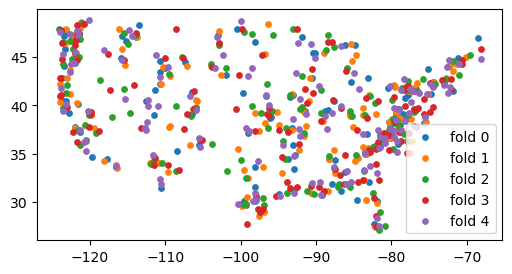

In [19]:
def get_cv_indices(df_basinid, nfold=5):
    from sklearn.model_selection import GroupKFold

    # Initialize GroupKFold
    group_kfold = GroupKFold(n_splits=nfold)

    # Dictionary to store train and test indices
    cv_indices = {}

    # Cross-validation process to save indices
    # does not depend on random seeds
    for fold, (train_index, test_index) in enumerate(group_kfold.split(df_basinid, groups=df_basinid['basin_num'])):
        
        train_basin = np.unique(df_basinid.iloc[train_index]['basin_id'].values)
        test_basin = np.unique(df_basinid.iloc[test_index]['basin_id'].values)

        cv_indices[fold] = {'train_index': train_index, 'test_index': test_index, 'train_basin': train_basin, 'test_basin': test_basin} 
    return cv_indices

# Get the indices
nfold = 5
cv_indices = get_cv_indices(df_basinid, nfold)

# plot test basin batches
fig = plt.figure(figsize=(6, 3))
for fold in range(len(cv_indices)):
    test_basin = cv_indices[fold]['test_basin']
    lat = df_basin_info.iloc[test_basin]['lat_cen'].values
    lon = df_basin_info.iloc[test_basin]['lon_cen'].values
    plt.scatter(lon, lat, 15, label=f'fold {fold}')

plt.legend()
plt.show()

## Random forest CV

In [32]:
from sklearn.ensemble import RandomForestRegressor



def rf_run_cross_validation_parallel(cv_indices, x_all, y_all, ncpus, samplestep, modelconfig={'n_estimators': 100, 'random_state': 42}):

    if True:

        rf_cv_results = {}
        
        # Cross-validation loop
        for fold, indices in cv_indices.items():
        
            # print(f"RF Fold {fold}")
        
            train_index = indices['train_index'][::samplestep]
            test_index = indices['test_index']
            
            x_train, x_test = x_all[train_index], x_all[test_index]
            y_train, y_test = y_all[train_index], y_all[test_index]
            
            # Initialize a new RandomForestRegressor for each fold
            rf_model = RandomForestRegressor(**modelconfig, n_jobs=ncpus)
            
            # Train the model
            rf_model.fit(x_train, y_train)
        
            # Predict on the test set
            y_test_pred = rf_model.predict(x_test)
            y_train_pred = rf_model.predict(x_train)

            if y_test_pred.ndim == 1 and y_test.ndim == 2:
                y_test_pred = y_test_pred[:, np.newaxis]
                y_train_pred = y_train_pred[:, np.newaxis]
            
            
            # Store results
            rf_cv_results[fold] = {
                # 'model': rf_model,
                'train_index': train_index,
                'test_index': test_index,
                'y_train': y_train,
                'y_test': y_test,
                'y_test_pred': y_test_pred,
                'y_train_pred': y_train_pred,
            }
        
    return rf_cv_results


def evaluate_cv(cv_results):
    # evaluation
    kge_test = np.nan * np.zeros([len(cv_results), cv_results[0]['y_train'].shape[1], 4]) #  kge, r, bias, relvar
    kge_train = np.nan * np.zeros([len(cv_results), cv_results[0]['y_train'].shape[1], 4])
    
    for fold in range(len(cv_results)):
        y_train, y_test, y_train_pred, y_test_pred = cv_results[fold]['y_train'], cv_results[fold]['y_test'], cv_results[fold]['y_train_pred'], cv_results[fold]['y_test_pred']
        
        # Evaluate the model using KGE
        for i in range(y_all.shape[1]):
            kge_test[fold - 1, i, :] = get_modified_KGE(y_test[:, i], y_test_pred[:, i])
            kge_train[fold - 1, i, :] = get_modified_KGE(y_train[:, i], y_train_pred[:, i])
    
    for i in [2, 3]:
        kge_test[:,:,i] = kge_test[:,:,i] - 1 # relative bias centering at 0
        kge_train[:,:,i] = kge_train[:,:,i] - 1

    return kge_test, kge_train

In [ ]:
%%time

# compare different model configs
modelconfigs = [ 
    {'n_estimators': 50, 'random_state': 42, 'max_depth': None}, 
    {'n_estimators': 100, 'random_state': 42, 'max_depth': None}, 
    {'n_estimators': 100, 'random_state': 42, 'max_depth': 10}, 
    {'n_estimators': 100, 'random_state': 42, 'max_depth': 20}, 
    {'n_estimators': 200, 'random_state': 42, 'max_depth': None}, 
    {'n_estimators': 200, 'random_state': 42, 'max_depth': 10}, 
    {'n_estimators': 200, 'random_state': 42, 'max_depth': 20}, 
]

samplestep = 20
for modelconfig in modelconfigs:
    rf_cv_results = rf_run_cross_validation_parallel(cv_indices, x_all, y_all, ncpus, samplestep, modelconfig)
    rf_kge_test, rf_kge_train = evaluate_cv(rf_cv_results)

    print(modelconfig)
    print(np.nanmean(rf_kge_train,axis=0))
    print(np.nanmean(rf_kge_test,axis=0))


{'n_estimators': 50, 'random_state': 42, 'max_depth': None}
[[ 9.35633752e-01  9.89168504e-01 -1.76727842e-04 -6.34475578e-02]]
[[ 0.56552479  0.67300109 -0.00195518 -0.28204385]]


In [ ]:
df_me

In [75]:
%%time

# compare different model configs
modelconfigs = [ 
    {'n_estimators': 100, 'random_state': 42, 'max_depth': 2},
    {'n_estimators': 100, 'random_state': 42, 'max_depth': 5},
    {'n_estimators': 100, 'random_state': 42, 'max_depth': 10}, 
    {'n_estimators': 100, 'random_state': 42, 'max_depth': 40}, 
]

samplestep = 20
for modelconfig in modelconfigs:
    rf_cv_results = rf_run_cross_validation_parallel(cv_indices, x_all, y_all, ncpus, samplestep, modelconfig)
    rf_kge_test, rf_kge_train = evaluate_cv(rf_cv_results)

    print(modelconfig)
    print(np.nanmean(rf_kge_train,axis=0))
    print(np.nanmean(rf_kge_test,axis=0))


{'n_estimators': 100, 'random_state': 42, 'max_depth': 2}
[[ 6.35835767e-01  7.64476260e-01  1.23710778e-04 -2.77544416e-01]
 [ 6.57177056e-01  7.80540237e-01 -1.19262498e-03 -2.63175276e-01]]
[[ 0.49276762  0.67985055 -0.0278576  -0.34917306]
 [ 0.47147357  0.6641736  -0.05975358 -0.34955327]]
{'n_estimators': 100, 'random_state': 42, 'max_depth': 5}
[[ 8.77370629e-01  9.45065340e-01 -7.19385972e-04 -1.09598558e-01]
 [ 8.42806997e-01  9.20630016e-01 -1.37754256e-03 -1.35586395e-01]]
[[ 0.67455507  0.81842241 -0.04155437 -0.24094997]
 [ 0.59639079  0.76623656 -0.06549946 -0.27748248]]
{'n_estimators': 100, 'random_state': 42, 'max_depth': 10}
[[ 9.64550325e-01  9.89560604e-01  4.00674997e-04 -3.38693093e-02]
 [ 9.34710571e-01  9.81947267e-01  1.53259148e-03 -6.26900271e-02]]
[[ 0.72097874  0.85612502 -0.02886477 -0.21007432]
 [ 0.63946781  0.79618504 -0.04016086 -0.24373193]]
{'n_estimators': 100, 'random_state': 42, 'max_depth': 40}
[[ 0.97927781  0.99668979  0.00136993 -0.02039843]
 

In [76]:
%%time

# choose a model to run and save
outfile = '/glade/work/guoqiang/CTSM_CAMELS/analyses/allbasin_emulator_rf.pkl'
samplestep = 1 # used to reduce input sample number (e.g., [::5])

if os.path.isfile(outfile):
# if False:
    with open(outfile, 'rb') as file:
        rf_cv_results = pickle.load(file)
    
else:
    rf_cv_results = rf_run_cross_validation_parallel(cv_indices, x_all, y_all, ncpus, samplestep, {'n_estimators': 100, 'random_state': 42})
    with open(outfile, 'wb') as file:
        pickle.dump(rf_cv_results, file)

    
rf_kge_test, rf_kge_train = evaluate_cv(rf_cv_results)
print(np.nanmean(rf_kge_train,axis=0))
print(np.nanmean(rf_kge_test,axis=0))

[[ 9.91131318e-01  9.98510191e-01  6.83278707e-04 -8.71566555e-03]
 [ 9.70729525e-01  9.94819944e-01  2.11502084e-03 -2.87299649e-02]]
[[ 0.7275339   0.82806608 -0.02883908 -0.17356376]
 [ 0.62990001  0.75687253 -0.02806891 -0.19421999]]
CPU times: user 99.9 ms, sys: 7.98 ms, total: 108 ms
Wall time: 197 ms


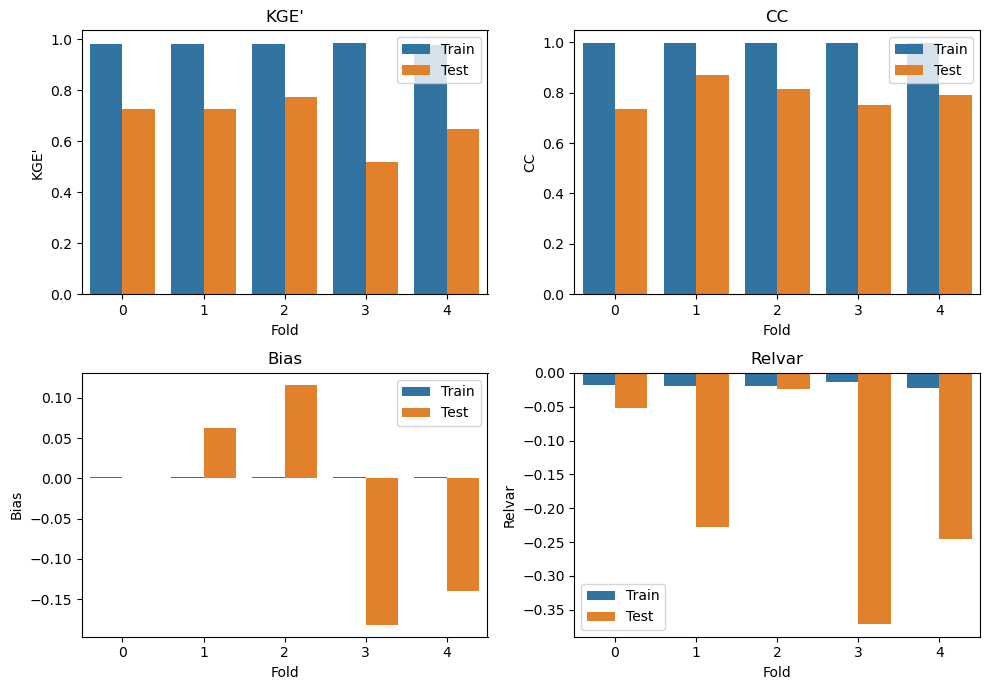

In [77]:

metnames = ["KGE'", "CC", "Bias", "Relvar"]

# Preparing data for seaborn
data = []
folds = np.arange(len(rf_cv_results))

for i in range(4):
    mtrain = rf_kge_train[:, :, i].mean(axis=1)
    mtest = rf_kge_test[:, :, i].mean(axis=1)
    
    for fold in folds:
        data.append([fold, mtrain[fold], 'Train', metnames[i]])
        data.append([fold, mtest[fold], 'Test', metnames[i]])

# Converting to a DataFrame
import pandas as pd

df = pd.DataFrame(data, columns=['Fold', 'Value', 'Dataset', 'Metric'])

# Plotting with seaborn
fig, axes = plt.subplots(2, 2, figsize=(10, 7))
axes = axes.flatten()

for i, ax in enumerate(axes):
    sns.barplot(x='Fold', y='Value', hue='Dataset', data=df[df['Metric'] == metnames[i]], ax=ax)
    ax.set_title(metnames[i])
    ax.set_xlabel('Fold')
    ax.set_ylabel(metnames[i])
    ax.legend()

plt.tight_layout()
plt.show()


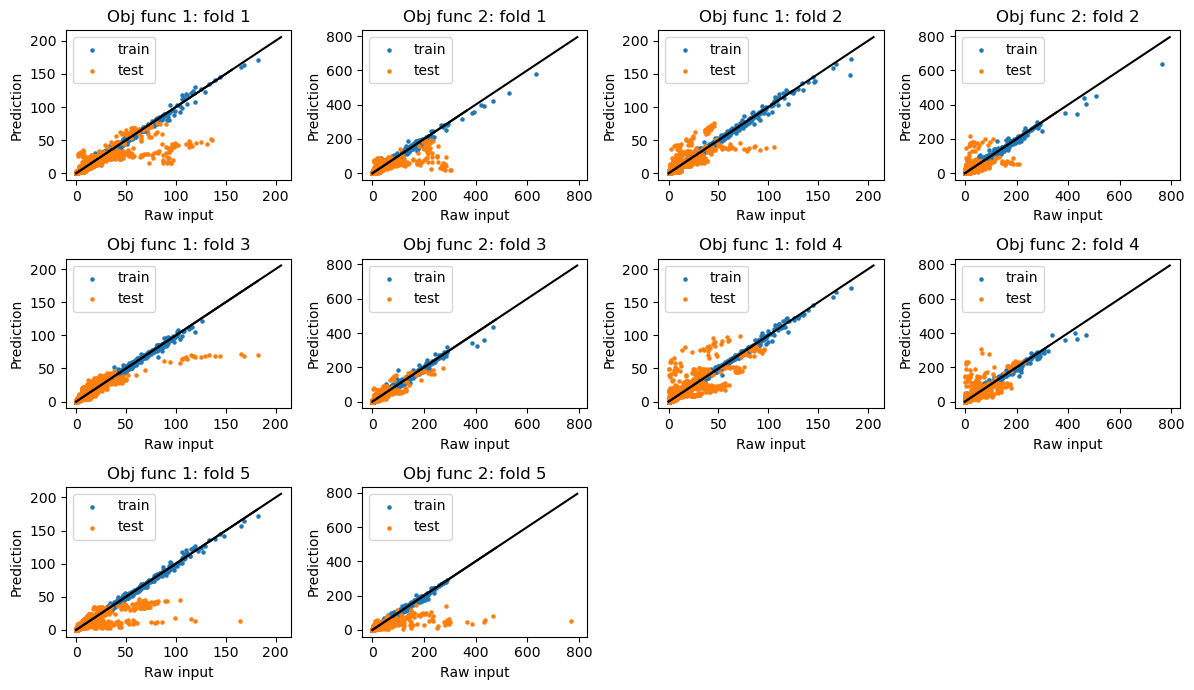

In [71]:
# scatter plots of CV results
fig = plt.figure(figsize=(12, 7))

step=20
markersize=5
flag = 1
for i in range(nfold):
    for j in range(2):
        fig.add_subplot(3, 4, flag)

        for t in ['train', 'test']:
            d1, d2 = rf_cv_results[i][f'y_{t}'][:,j], rf_cv_results[i][f'y_{t}_pred'][:,j]
            
            plt.scatter(d1[::step], d2[::step],markersize,label=t)
            lim1, lim2 = min(min(d1), min(d2)), max(max(d1), max(d2))
            plt.plot([lim1, lim2], [lim1, lim2], 'k')
            plt.title(f'Obj func {j+1}: fold {i+1}')
        
        plt.xlabel('Raw input')
        plt.ylabel('Prediction')
        plt.legend()
        
        flag = flag + 1


plt.tight_layout()
plt.show()


## BP network

In [72]:
from multiprocessing import Pool, cpu_count
from sklearn.neural_network import MLPRegressor


def bpnn_run_cross_validation_serial(cv_indices, x_all, y_all, ncpus, outfile):
    if os.path.isfile(outfile):
        with open(outfile, 'rb') as file:
            ann_cv_results = pickle.load(file)
    else:
        ann_cv_results = {}
        
        # Cross-validation loop
        for fold, indices in cv_indices.items():
        
            print(f"BP Fold {fold}")
        
            train_index = indices['train_index']
            test_index = indices['test_index']
            
            x_train, x_test = x_all[train_index], x_all[test_index]
            y_train, y_test = y_all[train_index], y_all[test_index]
            
            # Initialize a new MLPRegressor for each fold
            bp_model = MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000, random_state=42, n_iter_no_change=10)
            
            # Train the model
            bp_model.fit(x_train, y_train)
        
            # Predict on the test set
            y_test_pred = bp_model.predict(x_test)
            y_train_pred = bp_model.predict(x_train)
            
            # Store results
            ann_cv_results[fold] = {
                # 'model': bp_model,  # Optional: Comment this out to avoid large serialization
                'train_index': train_index,
                'test_index': test_index,
                'y_train': y_train,
                'y_test': y_test,
                'y_test_pred': y_test_pred,
                'y_train_pred': y_train_pred,
            }
        
        with open(outfile, 'wb') as file:
            pickle.dump(ann_cv_results, file)

    return ann_cv_results



def bpnn_train_and_evaluate_fold(args):
    fold, indices, x_all, y_all, samplestep, modelconfig = args
    # print(f"BP Fold {fold}")

    train_index = indices['train_index'][::samplestep]
    test_index = indices['test_index']
    
    x_train, x_test = x_all[train_index], x_all[test_index]
    y_train, y_test = y_all[train_index], y_all[test_index]
    
    # Initialize a new MLPRegressor for each fold
    bp_model = MLPRegressor(**modelconfig)
    
    # Train the model
    bp_model.fit(x_train, y_train)

    # Predict on the test set
    y_test_pred = bp_model.predict(x_test)
    y_train_pred = bp_model.predict(x_train)
    
    # Store results
    fold_result = {
        # 'model': bp_model,  # Optional: Comment this out to avoid large serialization
        'train_index': train_index,
        'test_index': test_index,
        'y_train': y_train,
        'y_test': y_test,
        'y_test_pred': y_test_pred,
        'y_train_pred': y_train_pred,
    }

    return fold, fold_result

def bpnn_run_cross_validation_parallel(cv_indices, x_all, y_all, ncpus, samplestep, modelconfig={'hidden_layer_sizes': (100,), 'max_iter': 2000, 'alpha': 0.001, 'random_state': 42, 'early_stopping': True}):

    with Pool(processes=ncpus) as pool:
        # Prepare arguments for each fold
        args = [(fold, indices, x_all, y_all, samplestep, modelconfig) for fold, indices in cv_indices.items()]
            
        # Parallelize the cross-validation loop
        results = pool.map(bpnn_train_and_evaluate_fold, args)
        
        # Collect results
        ann_cv_results = {fold: result for fold, result in results}

    return ann_cv_results


In [55]:
%%time

# compare ann configurations
modelconfigs = [
    # {'hidden_layer_sizes': (400,), 'max_iter': 1000, 'alpha': 0.001, 'random_state': 42, 'early_stopping': True},
    {'hidden_layer_sizes': (300,), 'max_iter': 1000, 'alpha': 0.0001, 'random_state': 42, 'early_stopping': True},
    {'hidden_layer_sizes': (200,), 'max_iter': 1000, 'alpha': 0.0001, 'random_state': 42, 'early_stopping': True},
    {'hidden_layer_sizes': (100,), 'max_iter': 1000, 'alpha': 0.0001, 'random_state': 42, 'early_stopping': True},
    # {'hidden_layer_sizes': (50,), 'max_iter': 2000, 'alpha': 0.0001, 'random_state': 42, 'early_stopping': True},
    {'hidden_layer_sizes': (50, 25), 'max_iter': 1000, 'alpha': 0.0001, 'random_state': 42, 'early_stopping': True},
    # {'hidden_layer_sizes': (50, 25), 'max_iter': 1000, 'alpha': 0.01, 'random_state': 42, 'early_stopping': True},
    # {'hidden_layer_sizes': (100, 50), 'max_iter': 1000, 'alpha': 0.001, 'random_state': 42, 'early_stopping': True},
    
    # {'hidden_layer_sizes': (300, 150), 'max_iter': 1000, 'alpha': 0.001, 'random_state': 42, 'early_stopping': True},
    # {'hidden_layer_sizes': (50, 25, 10), 'max_iter': 1000, 'alpha': 0.01, 'random_state': 42, 'early_stopping': True},
    # {'hidden_layer_sizes': (100, 50, 25), 'max_iter': 1000, 'alpha': 0.001, 'random_state': 42, 'early_stopping': True},
    
]


samplestep = 2
for modelconfig in modelconfigs:
    ann_cv_results = bpnn_run_cross_validation_parallel(cv_indices, x_all, y_all, 5, samplestep, modelconfig)
    ann_kge_test, ann_kge_train = evaluate_cv(ann_cv_results)

    print(modelconfig)
    print(np.nanmean(ann_kge_train,axis=0))
    print(np.nanmean(ann_kge_test,axis=0))


{'hidden_layer_sizes': (300,), 'max_iter': 1000, 'alpha': 0.0001, 'random_state': 42, 'early_stopping': True}
[[ 0.90351361  0.95755984 -0.02609408 -0.03037815]
 [ 0.81106972  0.89054276  0.00457059 -0.14173235]]
[[ 0.85960591  0.89782184 -0.03005046 -0.06119057]
 [ 0.71717984  0.82075704  0.00671839 -0.16148855]]
{'hidden_layer_sizes': (200,), 'max_iter': 1000, 'alpha': 0.0001, 'random_state': 42, 'early_stopping': True}
[[ 0.88315565  0.95665174  0.00499963 -0.08909712]
 [ 0.79339294  0.89127057 -0.07041613 -0.06058956]]
[[ 0.82270951  0.89516866  0.0137157  -0.11770672]
 [ 0.71001438  0.82303941 -0.09572222 -0.08921593]]
{'hidden_layer_sizes': (100,), 'max_iter': 1000, 'alpha': 0.0001, 'random_state': 42, 'early_stopping': True}
[[ 0.91512956  0.95865081 -0.01764568 -0.01856782]
 [ 0.83134866  0.89174542 -0.00356261 -0.10515261]]
[[ 0.85130481  0.90869944 -0.0140291  -0.05610751]
 [ 0.75999666  0.83089498 -0.00806819 -0.11094119]]
{'hidden_layer_sizes': (50, 25), 'max_iter': 1000, '

In [56]:
%%time

# compare ann configurations
modelconfigs = [
    {'hidden_layer_sizes': (100,), 'max_iter': 1000, 'alpha': 0.0001, 'random_state': 42, 'early_stopping': True, 'solver': 'adam'},
    {'hidden_layer_sizes': (100,), 'max_iter': 1000, 'alpha': 0.0001, 'random_state': 42, 'early_stopping': True, 'solver': 'sgd'},
    {'hidden_layer_sizes': (100,), 'max_iter': 1000, 'alpha': 0.0001, 'random_state': 42, 'early_stopping': True, 'solver': 'lbfgs'},
]


samplestep = 2
for modelconfig in modelconfigs:
    ann_cv_results = bpnn_run_cross_validation_parallel(cv_indices, x_all, y_all, 5, samplestep, modelconfig)
    ann_kge_test, ann_kge_train = evaluate_cv(ann_cv_results)

    print(modelconfig)
    print(np.nanmean(ann_kge_train,axis=0))
    print(np.nanmean(ann_kge_test,axis=0))


{'hidden_layer_sizes': (100,), 'max_iter': 1000, 'alpha': 0.0001, 'random_state': 42, 'early_stopping': True, 'solver': 'adam'}
[[ 0.91512956  0.95865081 -0.01764568 -0.01856782]
 [ 0.83134866  0.89174542 -0.00356261 -0.10515261]]
[[ 0.85130481  0.90869944 -0.0140291  -0.05610751]
 [ 0.75999666  0.83089498 -0.00806819 -0.11094119]]
{'hidden_layer_sizes': (100,), 'max_iter': 1000, 'alpha': 0.0001, 'random_state': 42, 'early_stopping': True, 'solver': 'sgd'}
[[-4.14237311e-01  8.47681678e-17  9.43634003e-04 -1.00000000e+00]
 [-4.14244653e-01  9.98931265e-17  2.32019025e-03 -1.00000000e+00]]
[[-0.42027455  0.00152632  0.02188266 -0.99975191]
 [-0.41737848  0.00415847  0.01766818 -0.99997969]]
{'hidden_layer_sizes': (100,), 'max_iter': 1000, 'alpha': 0.0001, 'random_state': 42, 'early_stopping': True, 'solver': 'lbfgs'}
[[ 0.90823695  0.9352587  -0.00527047 -0.06389052]
 [ 0.81893112  0.8713584  -0.00170719 -0.12730514]]
[[ 0.75638822  0.8248115   0.04445617 -0.02293042]
 [ 0.71566995  0.7

In [61]:
%%time

outfile = '/glade/work/guoqiang/CTSM_CAMELS/analyses/allbasin_emulator_ann.pkl'
samplestep = 1 # used to reduce input sample number (e.g., [::5])
if os.path.isfile(outfile):
# if False:
    with open(outfile, 'rb') as file:
        ann_cv_results = pickle.load(file)
else:
    modelconfig = {'hidden_layer_sizes': (100,), 'max_iter': 1000, 'alpha': 0.0001, 'random_state': 42, 'early_stopping': True}
    ann_cv_results = bpnn_run_cross_validation_parallel(cv_indices, x_all, y_all, 5, samplestep, modelconfig)
    with open(outfile, 'wb') as file:
        pickle.dump(ann_cv_results, file)

ann_kge_test, ann_kge_train = evaluate_cv(ann_cv_results)

print(np.nanmean(ann_kge_train,axis=0))
print(np.nanmean(ann_kge_test,axis=0))

[[ 0.8513534   0.96049543  0.04616028 -0.11598274]
 [ 0.83891251  0.89778995 -0.00605812 -0.12002714]]
[[ 0.80286871  0.90075249  0.05651062 -0.11137717]
 [ 0.76685256  0.82117585 -0.00144417 -0.11072106]]
CPU times: user 84.2 ms, sys: 36 ms, total: 120 ms
Wall time: 199 ms


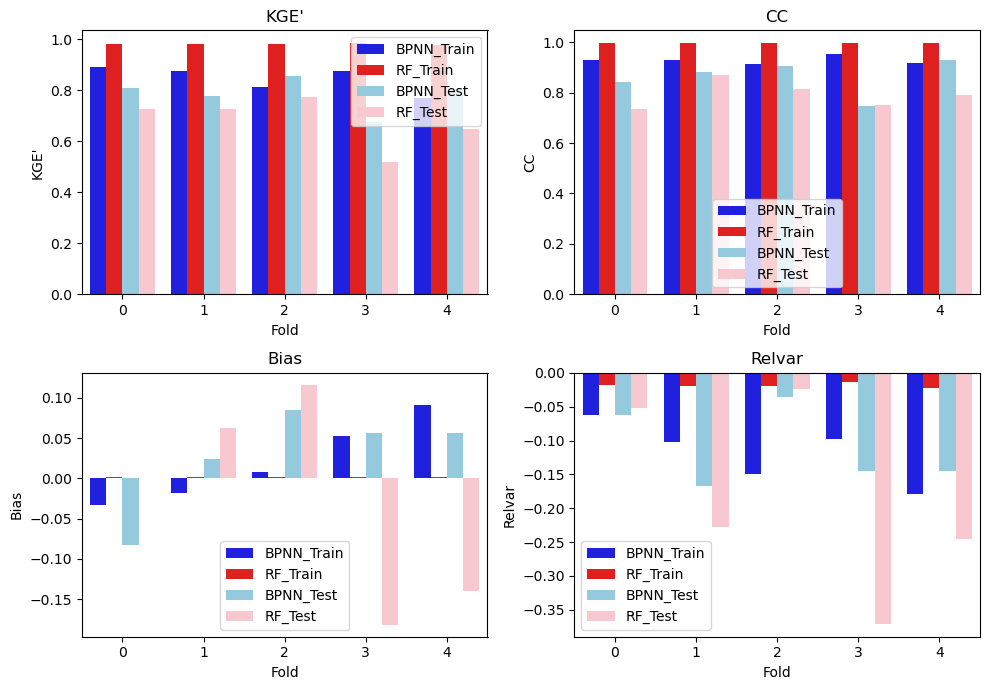

In [73]:
metnames = ["KGE'", "CC", "Bias", "Relvar"]

# Preparing data for seaborn
data = []
folds = np.arange(len(ann_cv_results))

for i in range(4):
    mtrain = ann_kge_train[:, :, i].mean(axis=1)
    mtest = ann_kge_test[:, :, i].mean(axis=1)

    mtrainrf = rf_kge_train[:, :, i].mean(axis=1)
    mtestrf = rf_kge_test[:, :, i].mean(axis=1)
    
    for fold in folds:
        data.append([fold, mtrain[fold], 'BPNN_Train', metnames[i]])
        data.append([fold, mtrainrf[fold], 'RF_Train', metnames[i]])
        data.append([fold, mtest[fold], 'BPNN_Test', metnames[i]])
        data.append([fold, mtestrf[fold], 'RF_Test', metnames[i]])

df = pd.DataFrame(data, columns=['Fold', 'Value', 'Dataset', 'Metric'])

# Plotting with seaborn
fig, axes = plt.subplots(2, 2, figsize=(10, 7))
axes = axes.flatten()
palette = {"BPNN_Train": "blue", "BPNN_Test": "skyblue", 
           "RF_Train": "red", "RF_Test": "pink"}

for i, ax in enumerate(axes):
    sns.barplot(x='Fold', y='Value', hue='Dataset', data=df[df['Metric'] == metnames[i]], ax=ax, palette=palette)
    ax.set_title(metnames[i])
    ax.set_xlabel('Fold')
    ax.set_ylabel(metnames[i])
    ax.legend()

plt.tight_layout()
plt.show()


# Get optimized parameters for each basin

In [16]:

# train an ANN model using all samples

outfile = '/glade/work/guoqiang/CTSM_CAMELS/analyses/allbasin_emulator_allsample_ann.pkl'
if os.path.isfile(outfile):
    with open(outfile, 'rb') as file:
        bp_model = pickle.load(file)
else:
    # Initialize a new MLPRegressor for each fold
    modelconfig = {'hidden_layer_sizes': (100,), 'max_iter': 1000, 'alpha': 0.0001, 'random_state': 42, 'early_stopping': True}
    bp_model = MLPRegressor(**modelconfig)
        
    # Train the model
    bp_model.fit(x_all, y_all)
    
    with open(outfile, 'wb') as file:
        pickle.dump(bp_model, file)
        
# Predict on the test set
y_pred = bp_model.predict(x_all)

# evaluation
kge_bp = np.zeros([2, 4])
for i in range(2):
    kge_bp[i, :] = get_modified_KGE(y_all[:, i], y_pred[:, i])

print(kge_bp)
        

[[0.94965182 0.96720761 0.96247681 0.99281607]
 [0.87103419 0.91023044 1.05135679 0.92295399]]


In [52]:
# %%time

file_sm_rf_optmz = f'/glade/work/guoqiang/CTSM_CAMELS/analyses/emulator_bpnn_allbasin_optmz_outputs.npz'
if os.path.isfile(file_sm_rf_optmz):
    d = np.load(file_sm_rf_optmz)
    bestx_sm_all_bpnn = d['bestx_sm_all_bpnn']
    besty_sm_all_bpnn = d['besty_sm_all_bpnn']

else:

   

    bestx_sm_all_bpnn = []
    besty_sm_all_bpnn = []
    
    # for tarbasin in range(len(df_basin_info)):
    for tarbasin in range(5):
        print(tarbasin)
    
        index = np.where(df_basinid["basin_num"].values == tarbasin)[0]
        hruid = df_basinid["hru_id"].values[index[0]]
        
        # attnames = [i for i in inputnames if not i in param_names]
        # attrvalues = df_input.iloc[index[0]][attnames].values
        
        param_lb_mean = df_param_lb.values[tarbasin, :]
        param_ub_mean = df_param_ub.values[tarbasin, :]

        attrvalues = x_all[index[0], len(param_lb_mean):] # same with df_input
        if np.any( attrvalues != df_input.iloc[index[0]][attnames].values):
            print('Warning! att problem')
    
        x_tar = x_all[index, :]
        y_tar = y_all[index, :]
        xlb_mean = np.hstack([param_lb_mean, attrvalues])
        xub_mean = np.hstack([param_ub_mean, attrvalues])
    
        nInput = len(xlb_mean)
        nOutput = 2
    
        pop = 100
        gen = 100
        crossover_rate = 0.9
        mu = 20
        mum = 20
    
        # define hyperparameter
        alpha = 1e-3
        leng_lb = 1e-3
        leng_ub = 1e3
        nu = 2.5
    
        bestx_sm, besty_sm, x_sm, y_sm = NSGA2.optimization(bp_model, nInput, nOutput, xlb_mean, xub_mean, pop, gen, crossover_rate, mu, mum,)
        D = NSGA2.crowding_distance(besty_sm)
        idxr = D.argsort()[::-1][:40]
        x_resample = bestx_sm[idxr, :]
        y_resample = besty_sm[idxr, :]
        
        bestx_sm_all_bpnn.append(bestx_sm)
        besty_sm_all_bpnn.append(besty_sm)
        
        # break
    # np.savez_compressed(file_sm_rf_optmz, bestx_sm_all_bpnn=bestx_sm_all_bpnn, besty_sm_all_bpnn=besty_sm_all_bpnn)

0
1
2
3
4


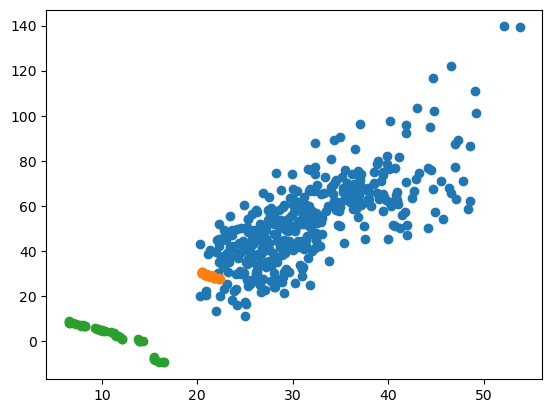

In [55]:
# check the performance of generated parameters

tarbasin = 4

file_indi = f'{inpath_moasmo}/level1_{tarbasin}_MOASMOcalib/param_sets/intermediate_output_iter1.pkl.npz'
dtmp = np.load(file_indi)
y_resample_indiv = dtmp['y_resample']


plt.scatter(y_tar[:,0], y_tar[:,1], label='realmodel')
plt.scatter(besty_sm[:,0], besty_sm[:,1], label='allbasin_pred')
plt.scatter(y_resample_indiv[:,0], y_resample_indiv[:,1], label='indivbasin_pred')